In [156]:
import time

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import scipy.stats as scs
from scipy.stats import multivariate_normal as mvn
import sklearn.mixture as mix
import copy
from pandas.plotting import scatter_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random

In [107]:
f = '/home/hendri/python_projects/samples/Untitled Folder/fraud_cc.csv'
# Take every N-th (in this case 10th) row
n = 500

# Count the lines or use an upper bound
num_lines = sum(1 for l in open(f))

# The row indices to skip - make sure 0 is not included to keep the header!
skip = [x for x in range(1, num_lines) if x % n != 0]


data = pd.read_csv(filepath_or_buffer = f, skiprows=skip)
# data.info()
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,5882.32,C278476563,10252.00,4369.68,M1479909053,0.00,0.00,0,0
1,1,PAYMENT,2284.54,C49318987,539.00,0.00,M1058650291,0.00,0.00,0,0
2,1,DEBIT,8648.45,C397318359,6734.00,0.00,C171493374,11010.00,0.00,0,0
3,1,PAYMENT,7363.65,C1687087217,1574226.59,1566862.94,M928734079,0.00,0.00,0,0
4,1,PAYMENT,7677.95,C1150436743,45881.29,38203.34,M407241000,0.00,0.00,0,0
5,2,PAYMENT,12710.27,C33238366,325690.00,312979.73,M387377349,0.00,0.00,0,0
6,2,PAYMENT,5374.49,C957608454,695819.48,690444.99,M65567135,0.00,0.00,0,0
7,3,DEBIT,5922.61,C512734831,17149.68,11227.07,C461160828,18493.88,24416.50,0,0
8,4,CASH_IN,64846.34,C394645908,6758299.24,6823145.58,C11003494,11364261.67,10946411.29,0,0
9,5,CASH_IN,50535.87,C189993695,4875810.94,4926346.82,C187649742,70183.75,19647.88,0,0


In [108]:
data[data.isnull().any(axis=1)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [109]:
flags = data.loc[:, data.columns == 'isFraud']


data  = data.drop(['isFraud','isFlaggedFraud'], axis=1)
columns = data.columns.values
print(columns)
data

['step' 'type' 'amount' 'nameOrig' 'oldbalanceOrg' 'newbalanceOrig'
 'nameDest' 'oldbalanceDest' 'newbalanceDest']


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,5882.32,C278476563,10252.00,4369.68,M1479909053,0.00,0.00
1,1,PAYMENT,2284.54,C49318987,539.00,0.00,M1058650291,0.00,0.00
2,1,DEBIT,8648.45,C397318359,6734.00,0.00,C171493374,11010.00,0.00
3,1,PAYMENT,7363.65,C1687087217,1574226.59,1566862.94,M928734079,0.00,0.00
4,1,PAYMENT,7677.95,C1150436743,45881.29,38203.34,M407241000,0.00,0.00
5,2,PAYMENT,12710.27,C33238366,325690.00,312979.73,M387377349,0.00,0.00
6,2,PAYMENT,5374.49,C957608454,695819.48,690444.99,M65567135,0.00,0.00
7,3,DEBIT,5922.61,C512734831,17149.68,11227.07,C461160828,18493.88,24416.50
8,4,CASH_IN,64846.34,C394645908,6758299.24,6823145.58,C11003494,11364261.67,10946411.29
9,5,CASH_IN,50535.87,C189993695,4875810.94,4926346.82,C187649742,70183.75,19647.88


In [157]:
datacp = copy.deepcopy(data)
cat_col =['type', 'nameOrig','nameDest']
for temp in cat_col:
    datacp[temp] = datacp[temp].astype('category')
print(datacp.dtypes)
datacp

step                 int64
type              category
amount             float64
nameOrig          category
oldbalanceOrg      float64
newbalanceOrig     float64
nameDest          category
oldbalanceDest     float64
newbalanceDest     float64
dtype: object


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,5882.32,C278476563,10252.00,4369.68,M1479909053,0.00,0.00
1,1,PAYMENT,2284.54,C49318987,539.00,0.00,M1058650291,0.00,0.00
2,1,DEBIT,8648.45,C397318359,6734.00,0.00,C171493374,11010.00,0.00
3,1,PAYMENT,7363.65,C1687087217,1574226.59,1566862.94,M928734079,0.00,0.00
4,1,PAYMENT,7677.95,C1150436743,45881.29,38203.34,M407241000,0.00,0.00
5,2,PAYMENT,12710.27,C33238366,325690.00,312979.73,M387377349,0.00,0.00
6,2,PAYMENT,5374.49,C957608454,695819.48,690444.99,M65567135,0.00,0.00
7,3,DEBIT,5922.61,C512734831,17149.68,11227.07,C461160828,18493.88,24416.50
8,4,CASH_IN,64846.34,C394645908,6758299.24,6823145.58,C11003494,11364261.67,10946411.29
9,5,CASH_IN,50535.87,C189993695,4875810.94,4926346.82,C187649742,70183.75,19647.88


In [158]:
for temp in cat_col:
    datacp[temp] = datacp[temp].cat.codes
    
datacp

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,3,5882.32,7902,10252.00,4369.68,9361,0.00,0.00
1,1,3,2284.54,9350,539.00,0.00,8422,0.00,0.00
2,1,2,8648.45,8715,6734.00,0.00,2963,11010.00,0.00
3,1,3,7363.65,4481,1574226.59,1566862.94,12439,0.00,0.00
4,1,3,7677.95,995,45881.29,38203.34,11306,0.00,0.00
5,2,3,12710.27,8272,325690.00,312979.73,11270,0.00,0.00
6,2,3,5374.49,12464,695819.48,690444.99,11831,0.00,0.00
7,3,2,5922.61,9496,17149.68,11227.07,5921,18493.88,24416.50
8,4,0,64846.34,8691,6758299.24,6823145.58,405,11364261.67,10946411.29
9,5,0,50535.87,5861,4875810.94,4926346.82,3680,70183.75,19647.88


In [113]:
data.shape

(12725, 9)

[[-1868107.04904968   775604.98132122]
 [-1870672.53688019   785179.08865687]
 [-1862077.97703889   782637.03637857]
 ...
 [-1861460.85806533   751939.74140776]
 [-1846717.50432935   715173.61730337]
 [   94820.52078208   941419.18092201]]
-----------------------


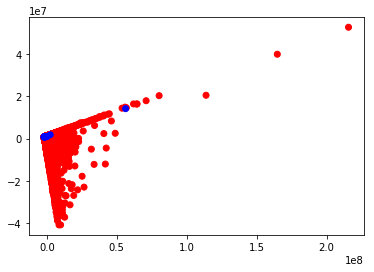

In [154]:

gmm = mix.GaussianMixture( n_components=2,max_iter=5000, covariance_type='tied')
gmm.fit(datacp)


classes = gmm.predict(datacp)
pca_c = PCA(n_components=2)
comp_data = pca_c.fit(datacp).transform(datacp)
print(comp_data)

colors = ['navy', 'turquoise']
lw = 2

tempdf = pd.DataFrame(data = classes, columns=['classes'])
list_color=[[0,'red'],[1,'blue']]
dfcolor = pd.DataFrame(data = list_color, columns=['classes','color'])
mergeddf = pd.merge(tempdf,dfcolor)

#Then we do the graph
plt.scatter(comp_data[:,0],comp_data[:,1],color=mergeddf['color'])
plt.show()


In [167]:
result = pd.Series(classes)
# print(result)

y = pd.Series(flags['isFraud'])
print('Jumlah cluster original label 0 : ',len(y[y==0].index))
print('Jumlah cluster from EM label 0 : ',len(result[result==0].index))

print('Jumlah cluster original label 1 : ',len(y[y==1].index))
print('Jumlah cluster from EM label 1 : ',len(result[result==1].index))

evaluation = (result == y)
print('True : ', len(evaluation[evaluation == True]))
print('False : ', len(evaluation[evaluation == False]))
false_idx = evaluation[evaluation == False].index
print(false_idx)
false_pos = [y[i] for i in false_idx if y[i] == 0]
false_neg = [y[i] for i in false_idx if y[i] == 1]

print()
print('false positive : ' , len(false_pos))
print('false negative : ' , len(false_neg))

Jumlah cluster original label 0 :  12709
Jumlah cluster from EM label 0 :  12712
Jumlah cluster original label 1 :  16
Jumlah cluster from EM label 1 :  13
True :  12696
False :  29
Int64Index([ 2060,  2109,  2118,  5129,  5699,  5750,  6515,  7221,  7337,
             7679,  7751,  7954,  8072,  8172,  8282,  8298,  8328,  8355,
             8357,  8358,  8367,  9185,  9198, 11975, 12129, 12336, 12525,
            12562, 12724],
           dtype='int64')

false positive :  13
false negative :  16
